## Notebook for spike sorting from .kwd data using the Pipeline of mountainsort (linux channel has pipeline)
Uses:
    - intan2kwik (https://github.com/zekearneodo/intan2kwik/blob/master/README.md)
    - mountainlab suite(https://github.com/flatironinstitute/mountainlab-js)
    - mountainsort https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md
    - mountainsort examples https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md

In [1]:
import socket
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from importlib import reload

# pipeline imports
from pipefinch.neural.convert import intan
from pipefinch.neural.sort.mountain import core as msc
from intan2kwik import kwd

#mountainsort imports (for sorting)
import mountainlab_pytools.mlproc as mlp

import logging

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')

2019-01-16 18:34:55,351 - root - INFO - Logger set


### functions and definitions to prepare the file structure

In [31]:
locations_dict = {};
locations_dict['zebra'] = {'mnt': os.path.abspath('/data/experiment'),
                  'local': os.path.abspath('/data/experiment')}
locations_dict['ZOROASTRO'] = {'mnt': os.path.abspath('B:\microdrive\data'),
                  'local': os.path.abspath('D:\microdrive')}

def get_exp_struct_from_hostname():
    hostname = socket.gethostname()
    return locations_dict[hostname]

def get_exp_struct():
    # get the configuration of the experiment:
    # if environment variable 'EXPERIMENT_PATH' exists, 
    # read 'EXPERIMENT_PATH/config/expstruct.json'
    exp_struct = dict()
    read_exp_base = os.environ.get('EXPERIMENT_PATH')
    if read_exp_base is not None:
        # if there is a .json file configured with the variables of the experiment
        exp_base = os.path.abspath(read_exp_base)
        exp_struct_json_path = os.path.join(exp_base, 'exp_struct.json')
        exp_struct = read_json_exp_struct()
    else:
        # try to read it from the hostname
        exp_struct = get_exp_struct_from_hostname()
    
    # make the exp struct dict.
    # Todo: said
    
    return exp_struct

### Session parameters and raw files

In [33]:
sess_par = {'bird': 'o3g3',
           'sess': 'awake_mix_test',
            'neural': 'neural'}

def get_file_structure(sess_par: dict):
    exp_struct = get_exp_struct()
    
    exp_struct['raw_folder'] = os.path.join(exp_struct['mnt'], sess_par['bird'], sess_par['neural'], sess_par['sess'])
    exp_struct['ss_folder'] = os.path.join(exp_struct['local'], sess_par['bird'], 'ss_data', sess_par['sess'])
    return exp_struct

file_struct = get_file_structure(sess_par)

logger.info('Raw folder {}'.format(file_struct['raw_folder']))

#list all the files in the session
#glob.glob(os.path.join(raw_folder, '*.rhd'))

### convert the whole session to a .kwd file
Conversion sends every .rhd file in the folder to a rec in the .kwd file (experiment.kwd in the session ss folder)
All of the files and all of the channels are converted; filtering and subselection of sub-epochs and channels occurs later.
The .kwd is raw data, only in a friendlier format.


In [8]:
## Convert the whole session to a kwd file
ss_folder = file_struct['ss_folder']
raw_folder = file_struct['raw_folder']
kwd_path = os.path.join(ss_folder, 'experiment.kwd')
bin_path = os.path.join(ss_folder, 'experiment.bin')
os.makedirs(ss_folder, exist_ok=True)
first_intan_hdr, sess_pd = kwd.intan_to_kwd(raw_folder, kwd_path)

2019-01-16 18:35:01,464 - intan2kwik.kwd - INFO - reading intan chans data across all of rec /data/experiment/o3g3/neural/awake_mix_test
2019-01-16 18:35:01,480 - intan2kwik.kwd - INFO - Found 5 .rhd files split in 3 recordings
2019-01-16 18:35:01,481 - intan2kwik.kwd - INFO - dest file: /data/experiment/o3g3/ss_data/awake_mix_test/experiment.kwd
2019-01-16 18:35:01,483 - intan2kwik.kwd - INFO - tmp path /tmp/tmp0omoo_yy/experiment.kwd


2019-01-16 18:37:54,828 - intan2kwik.kwd - INFO - moving back to /data/experiment/o3g3/ss_data/awake_mix_test/experiment.kwd
2019-01-16 18:38:19,547 - intan2kwik.kwd - INFO - removing temp file


In [9]:
from pipefinch.h5tools.kwik import kwdfunctions as kwdf
from pipefinch.h5tools.kwik import kutil

In [20]:
# use 'api' to read a dataset of a rec

In [24]:
kwd_file = h5py.File(kwd_path, 'r')

rec_dset = kwdf.get_data_set(kwd_file, 0)

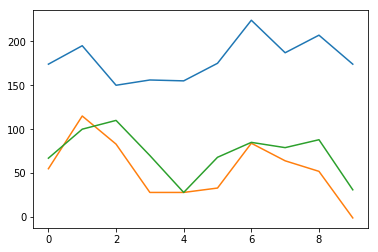

In [28]:
plt.plot(rec_dset[:10, :3])

## revisit reading a dataset

In [10]:
import h5py
from pipefinch.h5tools.core import tables

In [11]:
kwd_file = h5py.File(kwd_path, 'r')
dataset = kwd_file['/recordings/0/data']
print(dataset)

<HDF5 dataset "data": shape (12000240, 18), type "<i2">


In [12]:
all_dset = dataset.read_direct

In [13]:
# passing stuff to binary
reload(tables)

with open(bin_path, 'wb') as bf:
    stored = tables.dset_to_binary_file(dataset, bf, chan_list=None)

2019-01-16 18:38:24,050 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/0


KeyboardInterrupt: 

### what happens when attributes are lists of strings
(used while revisiting get_rec_attrs and h5_unicode_hack)

In [12]:
from pipefinch.h5tools.core import h5tools

In [87]:
attrs_path = '/recordings/0/application_data'
group_obj = kwd_file[attrs_path]

group_attrs = group_obj.attrs
#r_attrs = kwdf.get_rec_attrs()

reload(h5tools)
group_attrs_dict = h5tools.obj_attrs_2_dict_translator(group_obj)

### read all the meta of a kwd file into a pandas DataFrame

In [83]:
pd_meta.loc[pd_meta['name']==0, 'channel_names'].values

1

In [89]:
reload(kwdf)
pd_meta = kwdf.get_all_rec_meta(kwd_path)
pd_meta.head(5)


,bit_depth,sample_rate,name,start_sample,start_time,is_multiSampleRate_data,channels_sample_rate,channel_bit_volts,channel_names,valid_samples,samples_count
0,16,20000.0,0,0,2018-09-08 14:34:46,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-001, A-002, A-003, A-004, A-006, A-008, A-0...","[12000240.0, 12000240.0, 12000240.0, 12000240....",12000240
1,16,20000.0,1,0,2018-09-08 18:55:37,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-001, A-002, A-003, A-004, A-006, A-008, A-0...","[24000480.0, 24000480.0, 24000480.0, 24000480....",24000480
2,16,20000.0,2,0,2018-09-08 19:15:38,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[A-001, A-002, A-003, A-004, A-006, A-008, A-0...","[24000480.0, 24000480.0, 24000480.0, 24000480....",24000480


### Kwd file to mda 

## Select a subset of a kwd file:
 - a set of recordings (e.g, by range of time)
 - a set of channels (by identifier) (e.g: a whole port from the intan, like 'A-', or the channel where the mic is, like 'ADC-00')

In [17]:
np.unique(np.hstack(pd_meta.loc[:, 'channel_names'].values))

array(['A-001', 'A-002', 'A-003', 'A-004', 'A-006', 'A-008', 'A-010',
       'A-012', 'A-013', 'A-014', 'A-017', 'A-019', 'A-021', 'A-022',
       'A-023', 'A-026', 'A-028', 'ADC-00'], dtype='<U6')

In [18]:
reload(kwdf)
pd_meta = kwdf.get_all_rec_meta(kwd_path)

# Select channels:
wanted_chans = np.array(['A-', 'ADC'])

all_chan_names = kwdf.get_all_chan_names(pd_meta)

sel_chan_names = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)

#in this case, that's all the channels
sel_chan_names

array(['A-001', 'A-002', 'A-003', 'A-004', 'A-006', 'A-008', 'A-010',
       'A-012', 'A-013', 'A-014', 'A-017', 'A-019', 'A-021', 'A-022',
       'A-023', 'A-026', 'A-028', 'ADC-00'], dtype='<U6')

In [19]:
wanted_chans = np.array(['A-']) # all ephys channels
chan_list = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)

## Make .mda file with a set of recordings in a session
 - pick all in port A
 - get all rec within a time range


In [108]:
reload(kwdf)
reload(kutil)
ch.setLevel(logging.INFO)

all_rec_list = kutil.get_rec_list(kwd_path)
all_rec_list

wanted_chans = np.array(['ADC-00']) # all ephys channels
chan_list = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)

bin_path = os.path.join(ss_folder, 'experiment.bin')
bin_file = kwdf.kwd_to_binary(kwd_path, bin_path, chan_list=np.array(['ADC-00']), rec_list=np.array([0, 1, 2]), header='mda')
rec_attr_dict = kwdf.get_rec_attrs(kwd_path, 0)
all_rec_meta_pd = kwdf.get_all_rec_meta(kwd_path)

2018-12-24 23:05:55,663 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Writing kwd_file /data/experiment/raw_data/o3g3/ss_data/awake_mix_test/experiment.kwd to binary
2018-12-24 23:05:55,671 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Channels to extract: ['ADC-00']
2018-12-24 23:05:55,672 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Will go through recs [0 1 2]
2018-12-24 23:05:55,672 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Creating binary file /data/experiment/raw_data/o3g3/ss_data/awake_mix_test/experiment.bin


2018-12-24 23:05:55,720 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/0
2018-12-24 23:05:55,951 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/1
2018-12-24 23:05:56,384 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/2
2018-12-24 23:05:57,140 - pipefinch.h5tools.kwik.kwdfunctions - INFO - 60001200 elements written


In [97]:
rec_chans = pd_meta.loc[pd_meta['name']==0, 'channel_names'].values
kwdf.find_chan_names_idx(rec_chans[0], chan_list)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),)

#### test that the mda was written ok by looking at the microphone channel

In [15]:
from mountainlab_pytools import mdaio
loaded_mda = mdaio.readmda(bin_path)

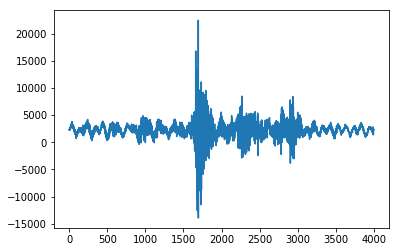

In [16]:
start = 8400000 + 30000
end = start + 4000
plt.plot(loaded_mda[:, start:end].T);

### tyr to fix the channel namimg

In [55]:
all_rec_meta_pd.head()

,bit_depth,sample_rate,name,start_sample,start_time,is_multiSampleRate_data,channels_sample_rate,channel_bit_volts,channel_names,valid_samples,samples_count
0,16,20000.0,0,0,0018-09-08 14:34:46,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'A-001', b'A-002', b'A-003', b'A-004', b'A-0...","[12000240.0, 12000240.0, 12000240.0, 12000240....",12000240
1,16,20000.0,1,0,0018-09-08 18:55:37,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'A-001', b'A-002', b'A-003', b'A-004', b'A-0...","[24000480.0, 24000480.0, 24000480.0, 24000480....",24000480
2,16,20000.0,2,0,0018-09-08 19:15:38,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'A-001', b'A-002', b'A-003', b'A-004', b'A-0...","[24000480.0, 24000480.0, 24000480.0, 24000480....",24000480


In [17]:
all_rec_meta_pd.loc[0, 'channel_names']

array([b'A-001', b'A-002', b'A-003', b'A-004', b'A-006', b'A-008',
       b'A-010', b'A-012', b'A-013', b'A-014', b'A-017', b'A-019',
       b'A-021', b'A-022', b'A-023', b'A-026', b'A-028', b'ADC-00'],
      dtype='|S6')

In [18]:
from pipefinch.h5tools.core import h5tools

kwd_file = h5py.File(kwd_path, 'r')

for k, v in kwd_file['/recordings/0/application_data'].attrs.items():
    print(k)

is_multiSampleRate_data
channels_sample_rate
channel_bit_volts
channel_names


In [19]:
kwd_file['/recordings/0'].attrs['start_time']

b'18-09-08 14:34:46'

In [26]:
kwd_file['/recordings/0/application_data'].attrs['is_multiSampleRate_data'].dtype

dtype('int64')

In [24]:
kwd_file['/recordings/0/application_data'].attrs['channel_names'].dtype

dtype('S6')

In [265]:
pd_slice = apd['name'].isin(np.array([0, 5, 7]))
apd.loc[pd_slice]

,bit_depth,sample_rate,name,start_sample,start_time,is_multiSampleRate_data,channels_sample_rate,channel_bit_volts,channel_names,valid_samples,channel_names_diff
0,16,20000.0,0,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[14556240.0, 14556240.0, 14556240.0, 14556240....",False
5,16,20000.0,5,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[207360.0, 207360.0, 207360.0, 207360.0, 20736...","[True, True, True, True, True, True, True, Tru..."
7,16,20000.0,7,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[774720.0, 774720.0, 774720.0, 774720.0, 77472...","[True, True, True, True, True, True, True, Tru..."


In [274]:
cmplist = diff_arrays(apd, 'channel_names')
cmp_arr = np.stack(cmplist[1:])
cmp_arr.all(axis=1)

/home/zinch/conda/envs/msort/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [278]:
apd.head()

,bit_depth,sample_rate,name,start_sample,start_time,is_multiSampleRate_data,channels_sample_rate,channel_bit_volts,channel_names,valid_samples,channel_names_diff
0,16,20000.0,0,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[14556240.0, 14556240.0, 14556240.0, 14556240....",False
1,16,20000.0,1,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[106560.0, 106560.0, 106560.0, 106560.0, 10656...","[True, True, True, True, True, True, True, Tru..."
2,16,20000.0,2,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[1199520.0, 1199520.0, 1199520.0, 1199520.0, 1...","[True, True, True, True, True, True, True, Tru..."
3,16,20000.0,3,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[308160.0, 308160.0, 308160.0, 308160.0, 30816...","[True, True, True, True, True, True, True, Tru..."
4,16,20000.0,4,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[1199520.0, 1199520.0, 1199520.0, 1199520.0, 1...","[True, True, True, True, True, True, True, Tru..."


In [277]:
cmp_arr.shape

(186, 14)

In [135]:
rec_attr_dict['app_data']['channel_names'][:10]

array([b'D-004', b'D-006', b'D-008', b'D-012', b'D-019', b'D-022',
       b'D-023', b'D-024', b'D-025', b'D-026'], dtype='|S6')

In [ ]:
def 

## Scripts for sorting

### prep the files with their nice formats, locations and names


In [142]:
rhd_list

NameError: name 'rhd_list' is not defined

In [143]:
ss_folder = os.path.join(exp_base, sess_par['bird'], 'ss_data', sess_par['sess'])

file_paths, out_folder = msc.make_paths(ss_folder)
os.makedirs(ss_folder, exist_ok=True)
#todo:
# meta and pars from intan files et al
s_f = 20000

# parameters to pass to the msort scripts
ds_params = {'samplerate': s_f,
            'detect_sign': -1}

with open(file_paths['params'], 'w') as fp:
    json.dump(ds_params, fp)
    logger.info('Created session par files {}'.format(file_paths['params']))
    
# create the mda file from the rhd_list
#intan_meta, samples_in = intan.intan_to_bin(rhd_list[:], file_paths['mda'], variant='mda');


2018-12-18 18:33:33,063 - root - INFO - Created session par files /home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/params.json


In [144]:
ds_params

{'samplerate': 20000, 'detect_sign': -1}

In [145]:
file_paths

{'mda': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/raw.mda',
 'params': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/params.json',
 'geom': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/geom.csv',
 'filt': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/filt.mda.prv',
 'pre': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/pre.mda.prv',
 'firings': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/firings.mda',
 'firings_curated': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/firings_curated.mda',
 'cluster_metrics': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/cluster_metrics.json'}

In [146]:
# test mountainsort method for reading sorting parameters
msc.read_dataset_params(ss_folder)

{'samplerate': 20000, 'detect_sign': -1}

In [147]:
# Initialize a pipeline
from mountainlab_pytools import mlproc as mlp
Pipeline=mlp.initPipeline();

JSProxyWidget(status='Not yet rendered')

In [148]:
msc.sort_dataset?

Signature: msc.sort_dataset(*, file_paths:dict, freq_min:int=300, freq_max:int=6000, adjacency_radius:int=1, detect_threshold:float=3, dispatch_method:str='run', opts:dict={})
Docstring: <no docstring>
File:      ~/repos/pipefinch/pipefinch/neural/sort/mountain/core.py
Type:      function


In [149]:
output_dir = os.path.join(ss_folder, 'sort_out');
# Pipeline was failing, need to debug this ('NameError: name 'widgets' is not defined')
# with Pipeline:
#     msc.sort_dataset(file_paths=file_paths, adjacency_radius=-1, detect_threshold=3, dispatch_method='add')

msc.sort_dataset(file_paths=file_paths, adjacency_radius=-1, detect_threshold=2, freq_min=600);

2018-12-18 18:33:33,152 - pipefinch.sort.mountain.comre - INFO - Bandpass filter


RUNNING: ml-run-process ephys.bandpass_filter --inputs timeseries:/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/raw.mda --parameters freq_max:6000 freq_min:600 samplerate:20000 --outputs timeseries_out:/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/filt.mda.prv


KeyboardInterrupt: 

In [ ]:
file_paths

## Command for viewing:
 - open up terminal with the environment msort
 - go go the ss_data folder for the session
 - run the command: qt-mountainview --raw raw.mda --filt sort_out/filt.mda.prv --pre sort_out/pre.mda.prv --samplerate=20000 --firings sort_out/firings.mda --cluster_metrics sort_out/cluster_metrics.json